In [81]:
import torch
from dinov1 import load_checkpoint, Organoid
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import gurobipy as gp
import torch.nn.functional as F
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import umap.umap_ as umap
from sklearn.metrics.pairwise import cosine_similarity

import tqdm
import cvxpy as cp

from hdbscan import HDBSCAN


import numpy as np
import cvxpy as cp


In [82]:


def compute_cc_metrics(embeddings, labels=None):
    """Helper function to compute correlation clustering metrics with balanced objective."""
    
    # === 1. Cosine Similarity Matrix ===
    sim = cosine_similarity(embeddings)
    np.fill_diagonal(sim, 1.0)
    
    # === 2. Adaptive Skalierung der Similarities ===
    q_low, q_high = np.quantile(sim, [0.1, 0.9])
    sim_scaled = (sim - q_low) / (q_high - q_low)
    sim_scaled = np.clip(sim_scaled, 0, 1)
    
    # # === 3. Visualisierung der Similarity Matrix ===
    # plt.figure(figsize=(10, 8))
    # plt.imshow(sim_scaled, cmap='viridis')
    # plt.colorbar()
    # plt.title('Cosine Similarity Matrix (scaled)')
    # plt.show()

    # # Histogramm zur Analyse
    # print(f"Min similarity: {sim_scaled.min():.4f}")
    # print(f"Max similarity: {sim_scaled.max():.4f}")
    # print(f"Mean similarity: {sim_scaled.mean():.4f}")
    # print(f"Median similarity: {np.median(sim_scaled):.4f}")
    
    # plt.figure(figsize=(10, 6))
    # plt.hist(sim_scaled.flatten(), bins=50)
    # plt.title('Distribution of Scaled Cosine Similarities')
    # plt.xlabel('Cosine Similarity')
    # plt.ylabel('Count')
    # plt.show()

    # === 4. Setup für Optimierungsproblem ===
    num_images = sim_scaled.shape[0]
    y = cp.Variable((num_images, num_images), boolean=True)

    objective = cp.Minimize(
        cp.sum(cp.multiply(sim_scaled, (1 - y))) +   # Trennkosten (bei hoher Ähnlichkeit teuer)
        cp.sum(cp.multiply(1 - sim_scaled, y))       # Verbindungskosten (bei niedriger Ähnlichkeit teuer)
    )

    # === 5. Constraints ===
    constraints = []

    # Transitivität
    for p in tqdm.tqdm(range(num_images), desc='Transitivity constraints'):
        for q in range(num_images):
            if p != q:
                for r in range(num_images):
                    if r != p and r != q:
                        constraints.append(y[p,q] + y[q,r] - y[p,r] <= 1)
                        constraints.append(y[p,q] + y[p,r] - y[q,r] <= 1)
                        constraints.append(y[p,r] + y[q,r] - y[p,q] <= 1)

    # Diagonale = 1
    for p in range(num_images):
        constraints.append(y[p,p] == 1)

    # Symmetrie
    for p in tqdm.tqdm(range(num_images), desc='Symmetry constraints'):
        for q in range(p + 1, num_images):
            constraints.append(y[p, q] == y[q, p])

    # === 6. Solve the problem ===
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.GUROBI, verbose=True)

    # === 7. Visualisierung der Lösungsmatrix ===
    y_solution = y.value
    # plt.figure(figsize=(10, 8))
    # plt.imshow(y_solution, cmap='binary')
    # plt.colorbar()
    # plt.title('Solution Matrix (y)')
    # plt.show()

    # Debug-Prints
    # print(f"Solution matrix shape: {y_solution.shape}")
    # print(f"Number of 1s in solution: {np.sum(y_solution > 0.5)}")
    # print(f"Number of 0s in solution: {np.sum(y_solution <= 0.5)}")

    return problem, y_solution


In [83]:
from gurobipy import GRB
import gurobipy as gp
import numpy as np
def compute_cc_metrics_gurobi(embeddings, labels=None):
    # Cosine similarity matrix
    sim = cosine_similarity(embeddings)
    np.fill_diagonal(sim, 1.0)

    # Scaling test
    q_low, q_high = np.quantile(sim, [0.1, 0.9])
    sim_scaled = (sim - q_low) / (q_high - q_low)
    sim_scaled = np.clip(sim_scaled, 0, 1)

    n = sim_scaled.shape[0]

    model = gp.Model("correlation_clustering")
    model.setParam("OutputFlag", 1)

    # Create binary variables y[i,j] ∈ {0,1}
    y = {}
    for i in range(n):
        for j in range(i, n):
            y[i, j] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}_{j}")
            if i != j:
                y[j, i] = y[i, j]  # symm

    model.update()

    # Objective: combine costs of joining & separating
    obj = gp.LinExpr()
    for i in range(n):
        for j in range(n):
            if i != j:
                cost_if_joined = 1 - sim_scaled[i, j]
                cost_if_separated = sim_scaled[i, j]
                obj += cost_if_joined * y[i, j] + cost_if_separated * (1 - y[i, j])
    model.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    for i in range(n):
        model.addConstr(y[i, i] == 1)

    for i in tqdm.tqdm(range(n), desc="Transitivity constraints"):
        for j in range(n):
            if i != j:
                for k in range(n):
                    if k != i and k != j:
                        model.addConstr(y[i, j] + y[j, k] - y[i, k] <= 1)
                        model.addConstr(y[i, j] + y[i, k] - y[j, k] <= 1)
                        model.addConstr(y[i, k] + y[j, k] - y[i, j] <= 1)

    model.optimize()

    # get solution
    y_solution = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            y_solution[i, j] = y[i, j].X if (i, j) in y else y[j, i].X

    return model, y_solution

In [84]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

def get_clustering_from_solution(y_solution):
    adj = (y_solution > 0.5).astype(int)
    np.fill_diagonal(adj, 1)
    graph = csr_matrix(adj)
    n_clusters, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    return labels

In [85]:
def compute_embedding(backbone, data_loader):
    device = next(backbone.parameters()).device
    embs_l = []
    imgs_l = []
    labels = []

    for img, label in data_loader:
        img = img.to(device)
        img_list = [img]
        embs = backbone(img_list) 
        embs_l.append(embs[0].detach().cpu())
        imgs_l.append(img.cpu())
        labels.extend(label)

    embs = torch.cat(embs_l, dim=0)
    imgs = torch.cat(imgs_l, dim=0)

    return embs, imgs, labels

In [86]:
# Pfad zum Checkpoint
checkpoint_path = "./logs/20250409_135629_random/trial_25/checkpoints/trial_25_checkpoint.pth"

# Checkpoint laden
model, trial_args, trial_number = load_checkpoint(checkpoint_path)

print(f"Successfully loaded checkpoint from trial {trial_number}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trial args: {trial_args}")

# Dataset und DataLoader vorbereiten
val_path = "./ds/organoid/test-100"
dataset_val_plain = Organoid(val_path, apply_transforms=False)
val_indices = range(len(dataset_val_plain))

dataloader_kwargs = {
    "pin_memory": True,
    "num_workers": 0,
}

val_data_loader = DataLoader(
    dataset_val_plain,
    batch_size=4,
    drop_last=False,
    sampler=SubsetRandomSampler(val_indices),
    **dataloader_kwargs
)

print("Computing embeddings...")
embs, imgs, true_labels = compute_embedding(model, val_data_loader)


Successfully loaded checkpoint from trial 25
Model parameters: 117358592
Trial args: {'out_dim': 98304, 'norm_last_layer': True, 'norm_in_head': True, 'pretrained': True, 'use_correlation_loss': False}
Computing embeddings...


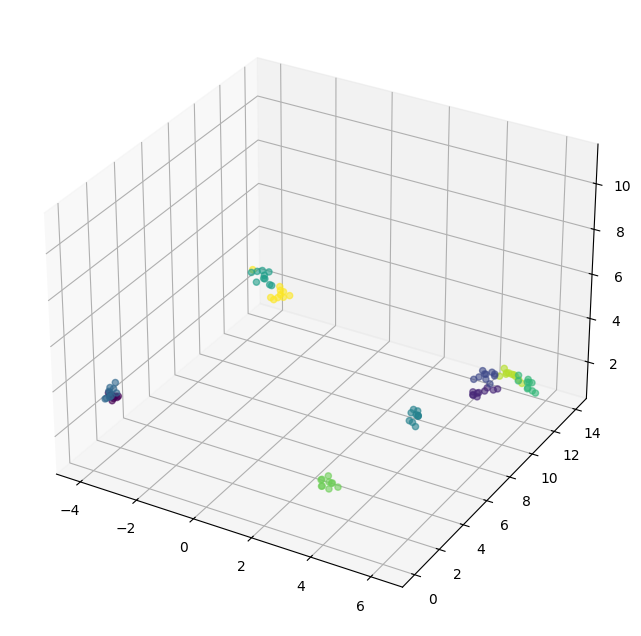

In [87]:
reducer = umap.UMAP(
    n_components=3,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
)
embs_3d = reducer.fit_transform(embs)
# Plot erstellen
plt.figure(figsize=(10, 8))
# 3D plot
ax = plt.axes(projection='3d')
ax.scatter(embs_3d[:, 0], embs_3d[:, 1], embs_3d[:, 2], c=true_labels, cmap='viridis', alpha=0.6)
plt.show()


c:\Users\kevin\Gits\uni\MLVC\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


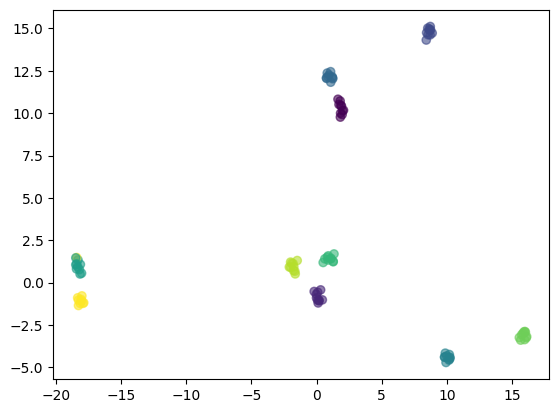

In [103]:
reducer_2d = umap.UMAP(
  n_components=2,
  n_neighbors=10,
  min_dist=0.1,
  random_state=15
)
embs_2d = reducer_2d.fit_transform(embs)

ax2d = plt.axes()
ax2d.scatter(embs_2d[:, 0], embs_2d[:, 1], 
             c=true_labels, cmap='viridis', alpha=0.6)
plt.show()

c:\Users\kevin\Gits\uni\MLVC\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\kevin\AppData\Local\Temp\ipykernel_42968\211541558.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10', len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))


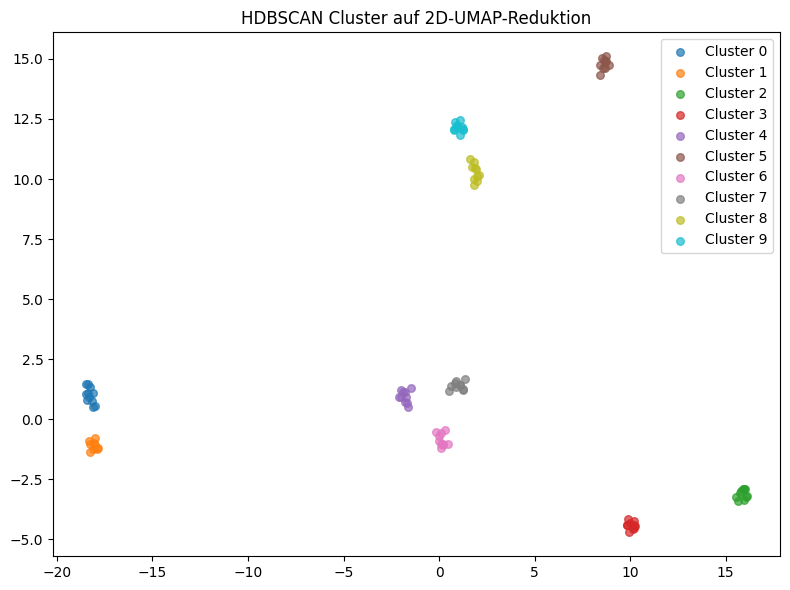

In [ ]:
reducer_2d = umap.UMAP(
  n_components=2,
  n_neighbors=10,
  min_dist=0.1,
  random_state=15
)
embs_2d = reducer_2d.fit_transform(embs)

# HDBSCAN-Clustering auf reduzierten Embeddings
clusterer = HDBSCAN()
cluster_labels = clusterer.fit_predict(embs_2d)

palette = plt.cm.get_cmap('tab10', len(set(cluster_labels)) - 
                          (1 if -1 in cluster_labels else 0))

fig, ax = plt.subplots(figsize=(8, 6))
for label in set(cluster_labels):
    mask = cluster_labels == label
    color = 'lightgray' if label == -1 else palette(label)
    ax.scatter(embs_2d[mask, 0], embs_2d[mask, 1], 
               s=30, c=[color], label=f'Cluster {label}' if label != -1 
               else 'Outlier', alpha=0.7)

ax.set_title("HDBSCAN Cluster auf 2D-UMAP-Reduktion")
ax.legend()
plt.tight_layout()
plt.show()

In [107]:

problem, y_sol = compute_cc_metrics_gurobi(embs, true_labels)
cluster_labels = get_clustering_from_solution(y_sol)

print(f"Number of clusters: {len(np.unique(cluster_labels))}")
print(f"Assignments: {cluster_labels}")

Transitivity constraints: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Academic license 2610266 - for non-commercial use only - registered to ke___@gmail.com
Optimize a model with 2910700 rows, 5050 columns and 8731900 nonzeros
Model fingerprint: 0x3f841cb2
Variable types: 0 continuous, 5050 integer (5050 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4303.6084468
Presolve removed 2425600 rows and 100 columns
Presolve time: 2.40s
Presolved: 485100 rows, 4950 columns, 1455300 nonzeros
Variable types: 0 continuous, 4950 integer (4950 binary)
Root relaxation presolved: 4950 rows, 490050 columns, 1460250 nonzeros


Root simplex log...

Iteration    Objective 

In [91]:
# problem, y_sol = compute_cc_metrics(embs_2d, true_labels)
# cluster_labels = get_clustering_from_solution(y_sol)

# print(f"Number of clusters: {len(np.unique(cluster_labels))}")
# print(f"Assignments: {cluster_labels}")


In [92]:
from sklearn.metrics import adjusted_rand_score, rand_score, normalized_mutual_info_score

def evaluate_clustering(pred_labels):
    print("=== Clustering Evaluation ===")
    print(f"Rand Index:               {rand_score(true_labels, pred_labels):.4f}")
    print(f"Adjusted Rand Index (ARI):{adjusted_rand_score(true_labels, pred_labels):.4f}")
    print(f"NMI (Normalized MI):      {normalized_mutual_info_score(true_labels, pred_labels):.4f}")


In [93]:
clusterer = HDBSCAN(min_cluster_size=5, metric='euclidean')  # oder 'cosine'
labels_orig = clusterer.fit_predict(embs)
labels_2d = clusterer.fit_predict(embs_2d)
labels_3d = clusterer.fit_predict(embs_3d)

evaluate_clustering(labels_orig)
evaluate_clustering(labels_2d)
evaluate_clustering(labels_3d)



=== Clustering Evaluation ===
Rand Index:               0.8525
Adjusted Rand Index (ARI):0.4331
NMI (Normalized MI):      0.7064
=== Clustering Evaluation ===
Rand Index:               0.9596
Adjusted Rand Index (ARI):0.7963
NMI (Normalized MI):      0.9359
=== Clustering Evaluation ===
Rand Index:               0.9962
Adjusted Rand Index (ARI):0.9768
NMI (Normalized MI):      0.9857


c:\Users\kevin\Gits\uni\MLVC\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


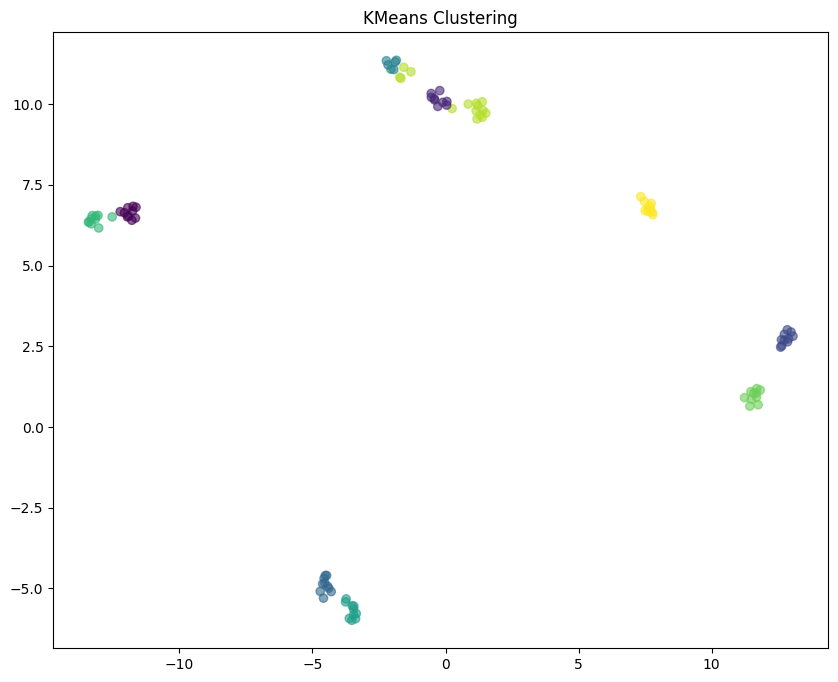

=== Clustering Evaluation ===
Rand Index:               0.9752
Adjusted Rand Index (ARI):0.8528
NMI (Normalized MI):      0.9236


In [94]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(embs)

plt.figure(figsize=(10, 8))
plt.scatter(embs_2d[:, 0], embs_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title('KMeans Clustering')
plt.show()

evaluate_clustering(labels)
